# Predicting Film Genre from Plot Summary: 
## Multilabel Classification and Natural Language Processing 

David S. White\
2020-06-07

## Goal: 
Use natural languague prcoessing (NLP) to predict the genre(s) of a movie using the plot summary provided each movie can feature up to three different genre labels (e.g. romantic, comedy) this is a multiclassification problem


## Libraries

In [1]:
import os 
import ast
import pandas as pd 
import numpy as np
import scipy as sp
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random 
sns.set()

# Data Cleaning & Exploration

## Load Dataset

In [2]:
df = pd.read_csv('movies_metadata.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


This dataset contains more features than we need to build this model. Overall, we need "genre" and "summary". Both datasets will need to be clean and encoded as Boolean arrays. When each feature is cleaned, they will be returned as a Pandas dataframe for later concatenation. 

## Clean "genre"

The "genre" of each item is currently one long list that needs to be reformatted into a list of strings. For example,
"['Action', 'Adventure', 'Drama']" to ['Action', 'Adventure', 'Drama'].  column "genre" needs to be reformatted via booleans for each genre 

Convert from json sting to list

In [4]:
df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [5]:
df['genres'][0]

['Animation', 'Comedy', 'Family']

function to grab a list of genres if they are included in a genre

In [6]:
def _encode_genres(old_genres, genres_to_encode=['All']):
    all_genres = list([])
    genre_list = list([])
    for i in range(0, len(old_genres)):
        temp = list([])
        for j in range(0, len(old_genres[i])):
            if genres_to_encode[0] == 'All': 
                all_genres.append(old_genres[i][j])
                temp.append(old_genres[i][j])
            else:
                for genre in genres_to_encode:
                    if old_genres[i][j] == genre:
                        all_genres.append(old_genres[i][j])
                        temp.append(old_genres[i][j])      
        genre_list.append(temp)    
        
    # to data frame 
    genre_df = pd.DataFrame({"genre":genre_list})
    
    # grab unique genres
    genre_labels = np.unique(all_genres)
    genre_labels = genre_labels.ravel()  # return to list 
    genre_labels = genre_labels .tolist()# return to list 
    
    return genre_df, all_genres, genre_labels

In [7]:
genre_df, genre_list_all, genre_labels_all = _encode_genres(df['genres'])

In [8]:
genre_labels_all

['Action',
 'Adventure',
 'Animation',
 'Aniplex',
 'BROSTA TV',
 'Carousel Productions',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'GoHands',
 'History',
 'Horror',
 'Mardock Scramble Production Committee',
 'Music',
 'Mystery',
 'Odyssey Media',
 'Pulser Productions',
 'Rogue State',
 'Romance',
 'Science Fiction',
 'Sentai Filmworks',
 'TV Movie',
 'Telescene Film Group Productions',
 'The Cartel',
 'Thriller',
 'Vision View Entertainment',
 'War',
 'Western']

Looking at the above list, there are clearly some issues with dataset for reporting genre. For example, "GoHands", "Pulser Productions" are not genres but production company. But, the list does show true genres, which are: 
* Action
* Adventure
* Animation
* Comedy
* Crime
* Documentary
* Drama
* Family
* Fantasy
* History
* Horror
* Music
* Mystery
* Science Fiction
* Thriller
* War
* Western

The function for encodin genres includes an option to encode specific genres. Therefore, we can encode these "true" genres and ignore the rest. Empty values will be dropped from the dataset once merged with plot description

In [9]:
genre_labels = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
               'History', 'Horror', 'Music', 'Mystery','Science Fiction', 'Thriller', 'War', 'Western']
genre_df, genre_list_all, genre_labels_all = _encode_genres(df['genres'], genre_labels)

In [10]:
genre_df

,genre
0,"[Animation, Comedy, Family]"
1,"[Adventure, Fantasy, Family]"
2,[Comedy]
3,"[Comedy, Drama]"
4,[Comedy]
...,...
45461,"[Drama, Family]"
45462,[Drama]
45463,"[Action, Drama, Thriller]"
45464,[]


There are clearly some movies that are missing a genre classification in the data. These values will be removed once the genre_df is merged with the text_df, which will be cleaned below. 

## Data Exploration: "Genre"

Now that genre is cleaned, let's see how often each genere appears. Additonally, since this is a multi-label problem, let's also determine how often genres appear together

### Frequency table of genre counts 

In [11]:
def _plot_frequency(all_labels, norm=0, max_labels = 100, figure_size =[8,16],
                   xlabel='Frequency',ylabel='Items',title='Frequency of Items',
                   savefig=0, figname=[]): 
    # all_labels = unique values to be counted
    fdist = nltk.FreqDist(all_labels) 
    labels = np.array(list(fdist.keys()))
    counts = np.array(list(fdist.values()))
    # sort by descending 
    sorted_idx = np.argsort(-1*counts)
    counts_sorted = counts[sorted_idx]
    labels_sorted = labels[sorted_idx]
    
    if len(counts_sorted) > max_labels:
        counts_sorted = counts_sorted[0:max_labels]
        labels_sorted = labels_sorted[0:max_labels]
    
    if norm:
        counts_sorted = (counts_sorted)/np.sum(counts_sorted)
    
    # plot the figure 
    fig=plt.figure(figsize=(figure_size[0],figure_size[1])) 
    ax = sns.barplot(counts_sorted, labels_sorted)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    
    if savefig:
        fig.savefig(figname, bbox_inches="tight")
    
    return counts


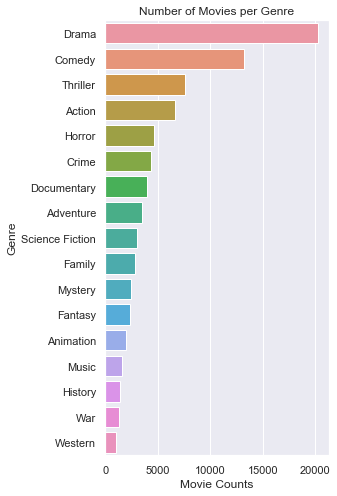

In [12]:
genre_counts = _plot_frequency(genre_list_all, figure_size =[4,8], 
                               xlabel='Movie Counts', ylabel='Genre', 
                               title='Number of Movies per Genre',
                              savefig=1, figname='genre_counts.png')

Some genres are clearly underrepresentred in the data (such as war and western films). However, all genres have a high number of counts and should be a good starting place to train a classifer. These field should also be checked to ensure they are well seperated. By this I mean, are all westerns also action movies? Are all horror movies also thrillers? If they values are well seperated, a classifer will be more reliable

### Genre Overlap

In [13]:
def _plot_overlap(genre_list, unique_labels, num_cols=3, num_rows=10):
    # a fast way to count each item is to convert to boolean array. This can be done with scikit-learn quickly
    from sklearn.preprocessing import MultiLabelBinarizer
    multilabel_binarizer = MultiLabelBinarizer()
    genre_list_bool = multilabel_binarizer.fit_transform(genre_list)
    
    # grab all counts 
    genre_freq = list([])
    for i in range(0, len(unique_labels)):
        idx = genre_list_bool[np.where(genre_list_bool[:,i] == 1)]
        counts = np.sum(idx,axis=0)
        freq = counts / counts[i]
        genre_freq.append(freq)

    # plot 
    fig = plt.figure(figsize=(num_cols*6, num_rows*6))
    for idx, col in enumerate(unique_labels):
        ax = fig.add_subplot(num_rows, num_cols, idx+1)
        sns.barplot(unique_labels, genre_freq[idx])
        ax.set(title= 'Overlap wih Genre: {0}'.format(col), xlabel='', ylabel='Normalized Counts')
        plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    return genre_freq

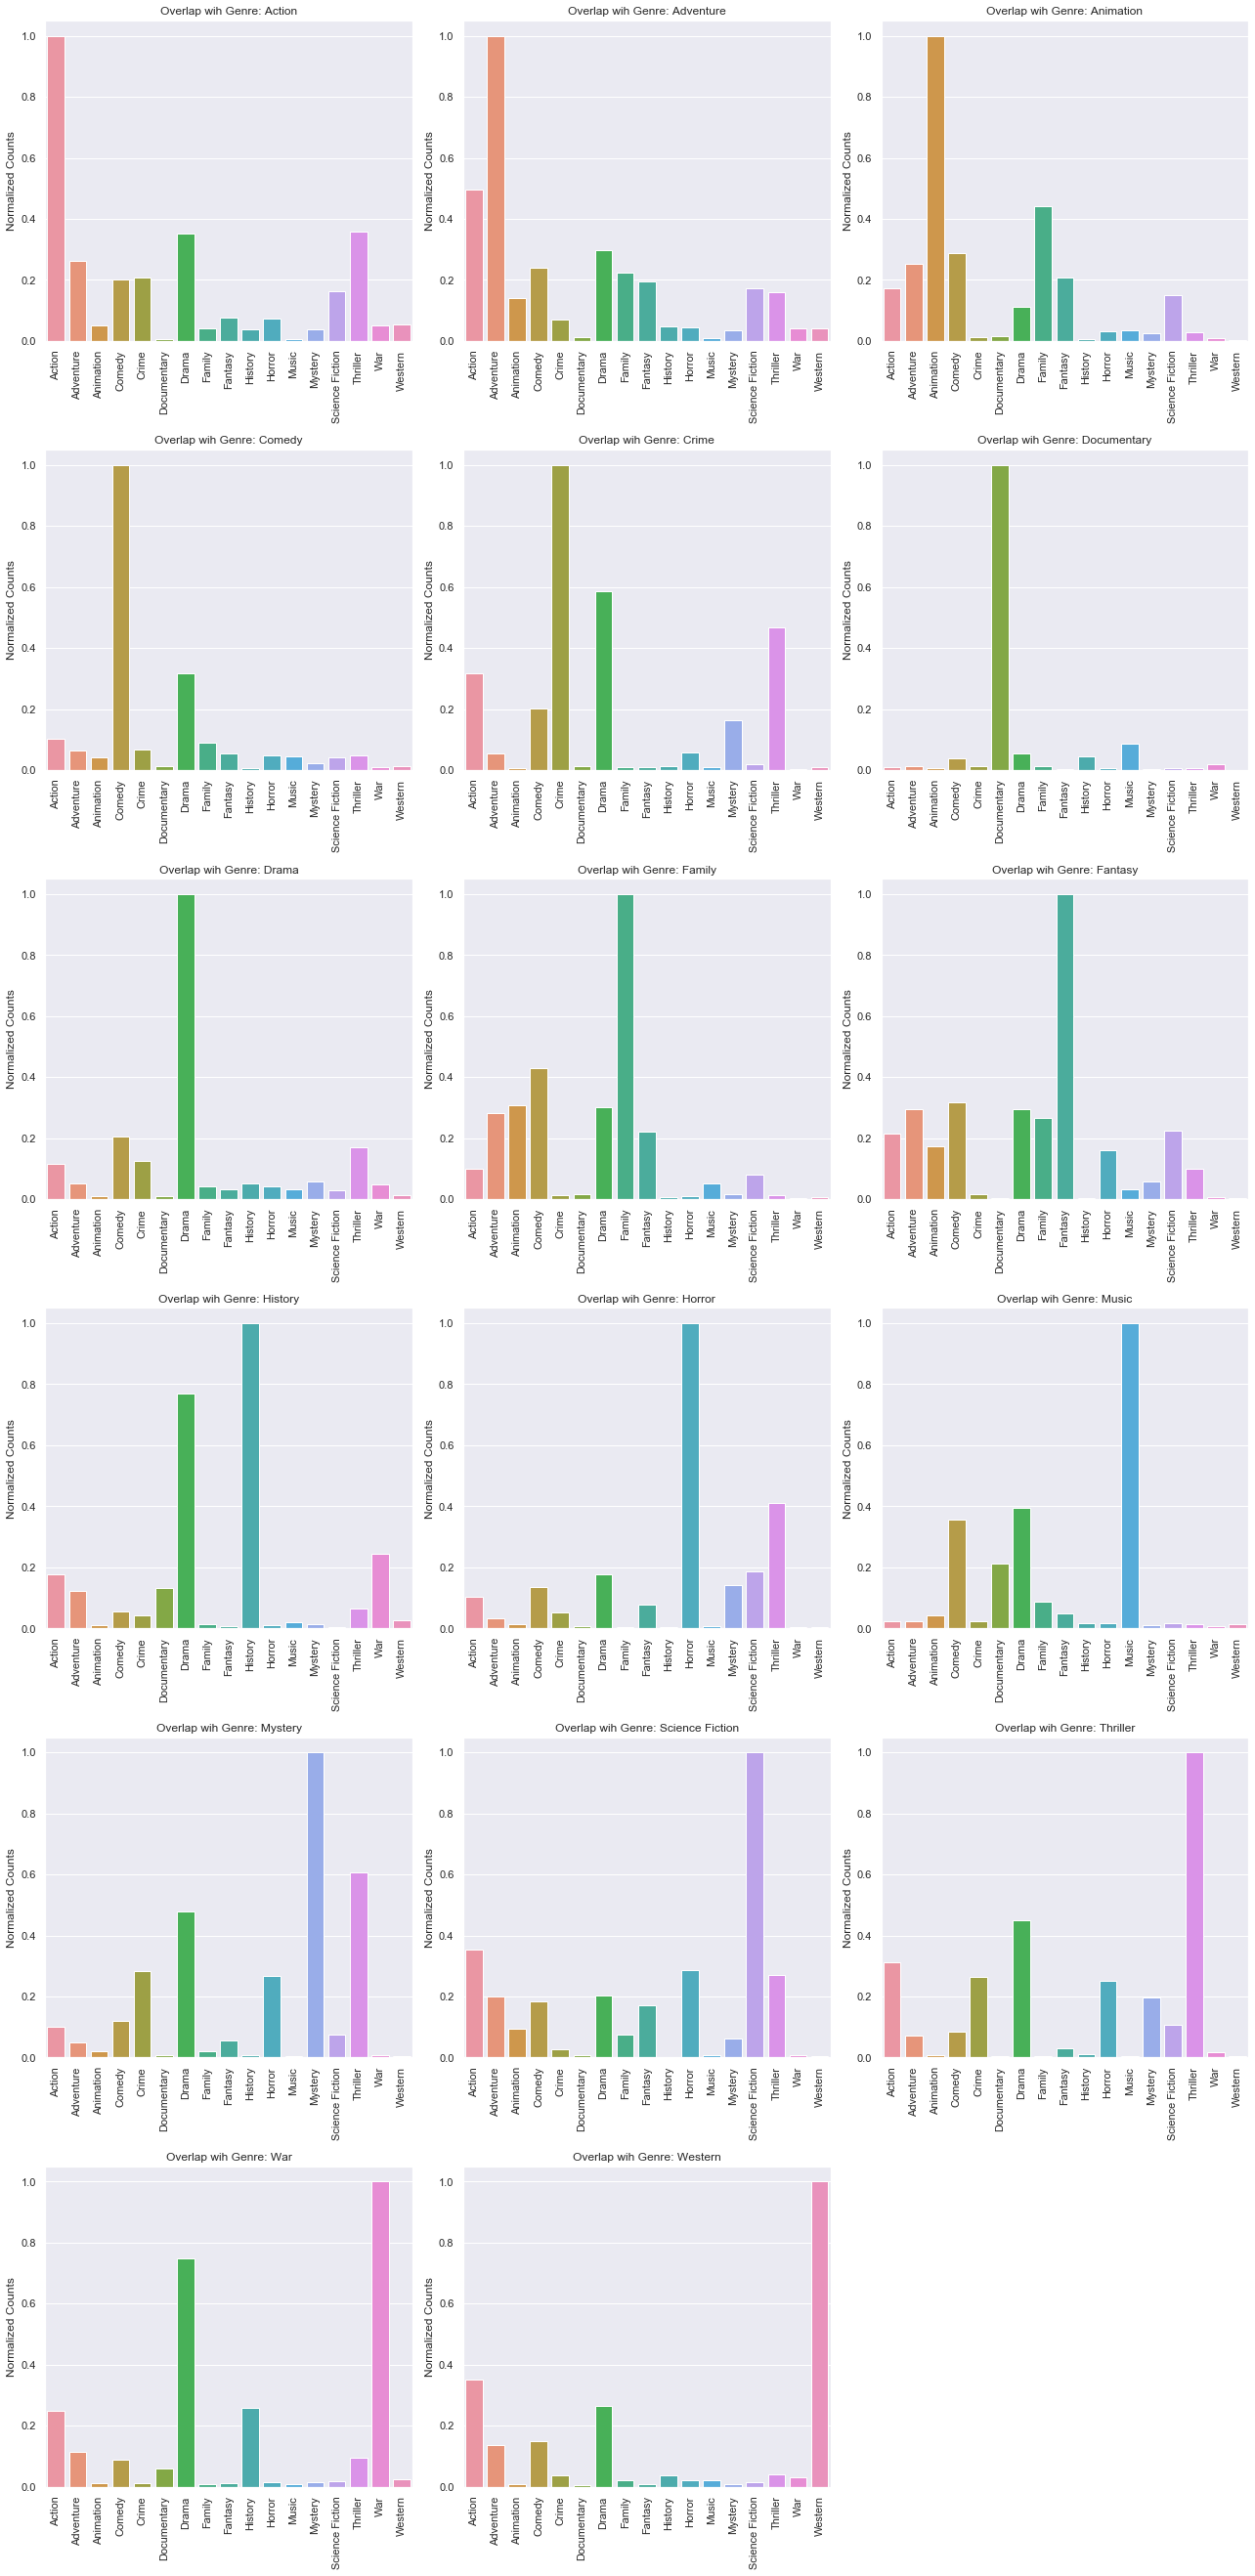

In [14]:
genre_freq = _plot_overlap(genre_df['genre'], genre_labels_all)

Some of these results are not surprising. For example
* High Overlap between Adventure w/ Action; Adentures, History w/ Drama;  Mystery w/ Thriller
* Comedy, Horror, and Western all are pretty independent categories

Overall though, most genres appear disctinct. Wordclouds will be used to see if there are unique words that make them appear distinct 

## Clean "summary" 

Summaries from IMDB are single sentence description of the plot. All sentences hould be in english and let's assume everything is grammatically correct and properly spelled. Steps in the NLP pipeline using the <code>nltk</code> library include: 
1. **Word Tokenization:** Break each sentence into seperate words. This will be accomplished using <code>word_tokenize</code> 
2. **Identifying Stop Words:** Remove filler words to reduce noise. This will be accomplished using <code>stopwords</code>. 

3. **Stem Words:** Return words to root form. This will be accomplished using <code>SnowballStemmer</code> 

*side note: a terrific introduction to NLP can be found here:* https://medium.com/@ageitgey/natural-language-processing-is-fun-9a0bff37854e

In [15]:
# make sure packages are up to date
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/dwhite7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dwhite7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
def _clean_text(summary, extra_stop_words=[]):
    
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    from nltk.stem.snowball import SnowballStemmer

    # make lower case 
    summary = summary.lower()
    
    # split into words and puncutation
    tokens = word_tokenize(summary)
    
    # remove stop words
    stop_words = set(stopwords.words('english'))
    if len(extra_stop_words) > 0:
        stop_words.update(extra_stop_words)
    words = [w for w in tokens if not w in stop_words]
    
    # stem words
    stemmer = SnowballStemmer('english')
    words  = [stemmer.stem(word) for word in words]
    
    # remove punctuation
    words = [word for word in words if word.isalpha()]
        
    sentence = ' '.join(words)    
        
    return words, sentence

test that our cleanText function is working as it should: 

In [17]:
summary = df['overview'][1]
words, sentence = _clean_text(summary)
print('Raw:', '\n', summary, '\n')
print('Cleaned:''\n', sentence)

Raw: 
 When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures. 

Cleaned:
 sibl judi peter discov enchant board game open door magic world unwit invit alan adult trap insid game year live room alan hope freedom finish game prove riski three find run giant rhinoceros evil monkey terrifi creatur


In [18]:
def _clean_text_all(all_summaries_old, extra_stop_words=[]):
    word_list = []
    all_summaries_new = []
    for i in range(0,len(all_summaries_old)):
        if isinstance(all_summaries_old[i], str):
            words, sentence =_clean_text(all_summaries_old[i], extra_stop_words)
        else: 
            words = []
            sentence = []
        word_list.extend(words)
        all_summaries_new.append(sentence)
    
    # make summaries into data frame 
    summary_df = pd.DataFrame({'text':all_summaries_new}, dtype='str')
    
    return summary_df, word_list

In [19]:
text_df, word_list = _clean_text_all(df['overview'])
text_df.head()

,text
0,led woodi andi toy live happili room andi birt...
1,sibl judi peter discov enchant board game open...
2,famili wed reignit ancient feud neighbor fish ...
3,cheat mistreat step women hold breath wait elu...
4,georg bank recov daughter wed receiv news preg...


Let's look at the most commonly used words in IMDB descriptions 

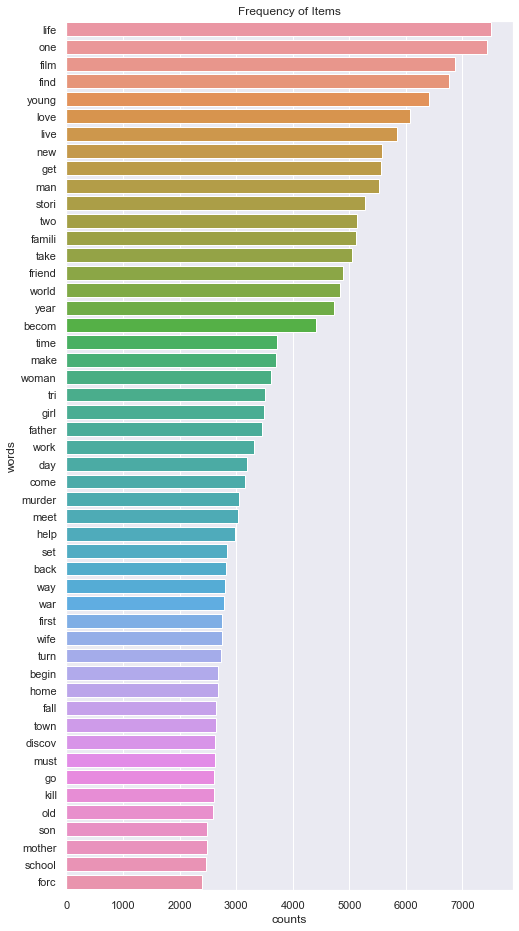

In [20]:
_plot_frequency(word_list, max_labels = 50)
plt.xlabel('counts')
plt.ylabel('words')
plt.show()

On a first pass, we are getting meaninful words, such as *secret*, *school*, *teenag*, *war*, *mysteri*. However, there is stil noise from number words (*one, two, there, etc...*) that can be removed. The <code>_clean_text</code> function I wrote takes a second argument to add in custom stop-words to remove.

In [21]:
extra_stop_words = ['one','two','three','four','five','six','seven','eight','nine','ten', 'find','finds']
text_df, word_list = _clean_text_all(df['overview'], extra_stop_words)

In [22]:
temp = np.array(word_list)
print('Number of unique words:', len(np.unique(temp)), 'of', len(temp))

Number of unique words: 55283 of 1329373


# Merge Data Frames
Both data sets "genre" and "summary" are now cleaned. Let's merge them. Drop values that are empty in either *genre* or *text* rather than replace with mean

In [23]:
df_new = pd.concat([genre_df, text_df], axis=1, sort=False)
start_length = len(df_new)

In [24]:
to_remove = []
for i in range(0, len(df_new)):
    if df_new['genre'][i]==[]:
        to_remove.append(i)
    elif df_new['text'][i]==[]:
        to_remove.append(i)

In [25]:
df_new = df_new.drop(to_remove)
df_new = df_new.reset_index(drop=True)

In [26]:
print('Number of Values Dropped: ', len(to_remove), ' of ', start_length)

Number of Values Dropped:  3292  of  45466


now remove frames without genre and/or text

# Data Exploration: Words per Genre 
The word list is looking promising and show words that should be meaningful. To visualize common words among genres, let's go ahead and generate word clouds.

In [27]:
def _make_word_cloud(df, genre_list, num_rows=6, num_cols=3, plot_size=[12,24],
                    savefig=0, figname=[]):
    fig = plt.figure(figsize=(plot_size[0],plot_size[1]))
    num_items= len(df)
    for idx, genre in enumerate(genre_list):
        genre_words = []
        for i in range(0, len(df)):
            genre_list = df['genre'][i]
            for g in genre_list: 
                if g == genre:
                    words = df['text'][i].split()
                    genre_words.extend(words)
        genre_words = ' '.join(genre_words)
    
        # now make the word cloud 
        
        wordcloud = WordCloud(width = 1000, height = 1000, 
                    background_color ='white',
                    random_state=42,
                    min_font_size = 10).generate(genre_words)
        ax = fig.add_subplot(num_rows, num_cols, idx+1)
        #plt.figure(figsize=(5,5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Gerne: '+genre)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    if savefig:
        fig.savefig(figname, bbox_inches="tight")

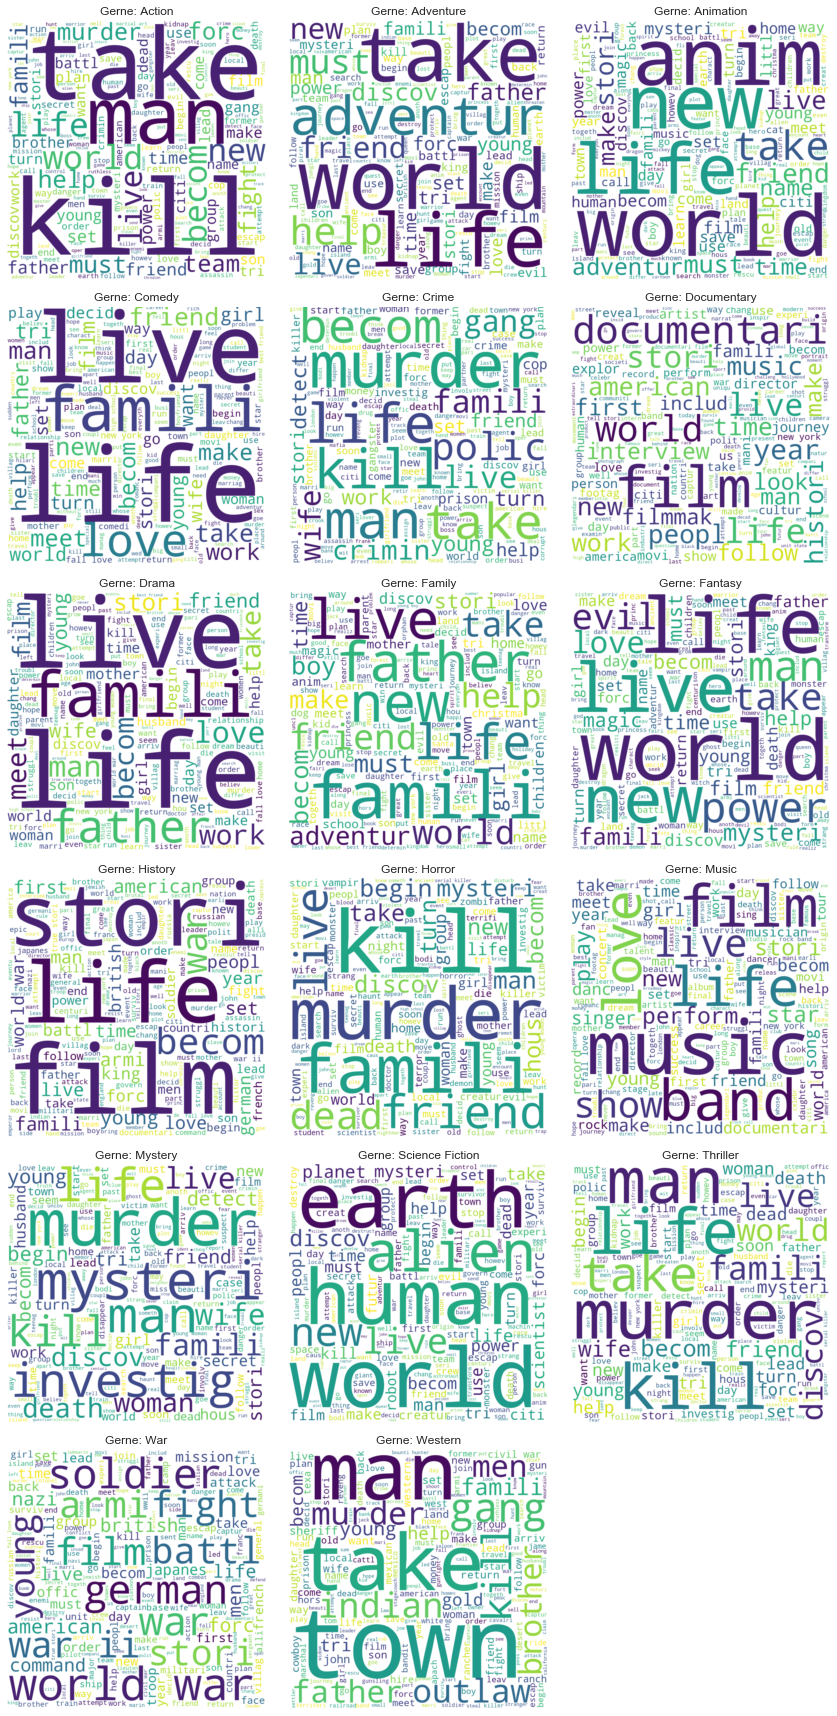

In [28]:
_make_word_cloud(df_new, genre_labels)

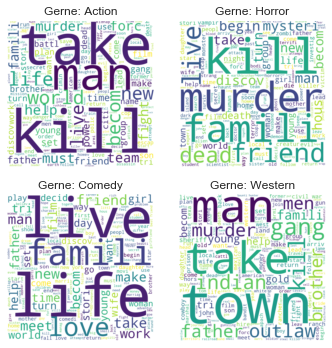

In [29]:
# make an example wordcloud to save for the README
genre_labels_temp = ['Action','Horror', 'Comedy','Western']
_make_word_cloud(df_new, genre_labels_temp,num_rows=2, num_cols=2,
                 plot_size=[5,5], savefig=1, figname='word_cloud_example.png')

Very intersting result. Some genres are clearly distinct in their plot descriptions, such as War and Science Fiction. Something interesting to note is that Comedy and Drama share a lot of the same words. This could be do an overlap of the genres, forming a "drama-comedy" subcategory; or it could be that the plots overlap and the difference between a comedy and drama is the tone of the film. Also, the words "life", "man", live" are used in most genres; should probably drop the most common words across all data in the model below.

# Model Building: 
**Goal** Build a multilabel classifer to predict the genre of each movie from its plot summary

## Split new dataframe into Testing and Training Set (80/20)

In [30]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_new, test_size=0.2, random_state=42)

## Encode all genres using one-hot encoder

In [31]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_train['genre'])
y_train = multilabel_binarizer.transform(df_train['genre'])

## Convert Text to features
let's start by looking at top 5000 words

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.99, max_features=5000)
X_train = tfidf_vectorizer.fit_transform(df_train['text'])

## Start Building a Model

Model training will use the F1 Score

<br>
<br>
$$ F1 = 2\times \frac {precision  \times  recall}{precision +recall} = \frac{TP}{TP + {\frac{FN + FP} {2}}}$$

where: 
* TP = True Positive 
* FP = False Positive
* FN = False Negative 

## Model 1: Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

lr_clf = OneVsRestClassifier(LogisticRegression())
lr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [34]:
y_pred = lr_clf.predict(X_train)
f1 = f1_score(y_train, y_pred, average="micro")
print('F1 Score:', "%.4f" %f1)

F1 Score: 0.4600


### Threshold-Moving
On a first pass, the F1 score is not too shabby. Let's see if this value can be improved by changing the threshold. A simple loop over a number of possible thresholds can be used to maxmize the F1 score

In [35]:
def findOptimalThreshold(X, y, clf, num_thresholds=101, show_figure=1):
    thresholds = np.linspace(0, 1, num=num_thresholds)
    y_pred_prob = clf.predict_proba(X)
    best_threshold = 0
    best_f1 = 0
    f1_all = np.zeros(len(thresholds))
    for i in range(0, len(thresholds)):
        y_pred = (y_pred_prob >= thresholds[i]).astype(int)
        f1_all[i] = f1_score(y, y_pred, average="micro")
        if f1_all[i] > best_f1:
            best_threshold = thresholds[i]
            best_f1 =  f1_all[i]
    
    if show_figure:
        plt.figure(figsize=(8,4)) 
        plt.plot(thresholds, f1_all)
        plt.scatter(best_threshold, best_f1, color='r')
        plt.xlabel('Threshold')
        plt.ylabel('F1 Score')
        plt.show()
    
    return best_f1, best_threshold

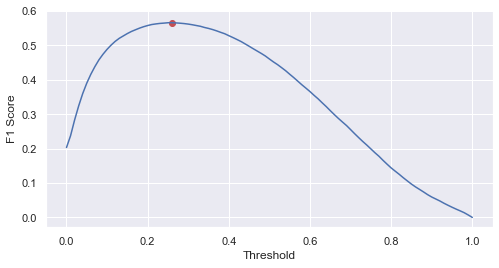

F1 Score:  0.5654
Threshold:  0.2600


In [36]:
best_f1, best_threshold = findOptimalThreshold(X_train, y_train, lr_clf)
print('F1 Score: ', "%.4f" %best_f1)
print('Threshold: ', "%.4f" %best_threshold)

In [37]:
def printScores(X, y, clf, threshold=0.5):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    y_pred_prob = clf.predict_proba(X)
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    p = precision_score(y, y_pred,average="micro")
    r = recall_score(y, y_pred, average="micro")
    f1 = f1_score(y, y_pred, average="micro")
    print('Precision:', "%.3f" %p)
    print('Recall:', "%.3f" %r)
    print('F1:', "%.3f" %f1)

In [38]:
printScores(X_train, y_train, lr_clf, threshold=0.5)
printScores(X_train, y_train, lr_clf, threshold=best_threshold)

Precision: 0.686
Recall: 0.346
F1: 0.460
Precision: 0.514
Recall: 0.629
F1: 0.565


In [39]:
def _test_predict_genre(X, y, clf, thresholds=[0.5]):
    rand_idx = random.randint(0,len(y))
    
    y_pred_prob = clf.predict_proba(X[rand_idx])
    y_pred_def = (y_pred_prob >= thresholds[0]).astype(int)
    if len(thresholds) > 1:
        y_pred_opt = (y_pred_prob >= thresholds[1]).astype(int)
    
    print('True:', '\n',multilabel_binarizer.inverse_transform(y_train)[rand_idx])
    print('Threshold :', thresholds[0], '\n',multilabel_binarizer.inverse_transform(y_pred_def))
    if len(thresholds) > 1:
        print('Threshold :', thresholds[1], '\n',multilabel_binarizer.inverse_transform(y_pred_opt))
    print('\n')
    

In [40]:
for i in range(0, 5):
    _test_predict_genre(X_train, y_train, lr_clf, [0.5, best_threshold])

True: 
 ('Action', 'Animation', 'Fantasy', 'Horror')
Threshold : 0.5 
 [('Horror',)]
Threshold : 0.26 
 [('Horror', 'Science Fiction', 'Thriller')]


True: 
 ('Drama',)
Threshold : 0.5 
 [('Drama',)]
Threshold : 0.26 
 [('Drama',)]


True: 
 ('Drama',)
Threshold : 0.5 
 [('Drama',)]
Threshold : 0.26 
 [('Drama',)]


True: 
 ('Fantasy', 'Mystery', 'Thriller')
Threshold : 0.5 
 [()]
Threshold : 0.26 
 [('Comedy', 'Drama', 'Horror', 'Thriller')]


True: 
 ('Horror', 'Mystery')
Threshold : 0.5 
 [()]
Threshold : 0.26 
 [('Comedy', 'Drama', 'Horror')]




As expected, the default threshold=0.5 which is higher than the threshold corresponding to the optimal F1 scores tends to underfit the labels, whereas the *optimal threshold* tends to over-fit 

## Performance on test-set

In [41]:
X_test = tfidf_vectorizer.transform(df_test['text'])
y_test = multilabel_binarizer.transform(df_test['genre'])

y_test_pred_prob = lr_clf.predict_proba(X_test)
y_test_pred = (y_test_pred_prob >= best_threshold).astype(int)

In [42]:
for i in range(0, 5):
    _test_predict_genre(X_test, y_test, lr_clf, [best_threshold])

True: 
 ('Music',)
Threshold : 0.26 
 [('Action', 'Drama')]


True: 
 ('Drama', 'Family')
Threshold : 0.26 
 [('Comedy', 'Drama', 'Music')]


True: 
 ('Animation', 'Family')
Threshold : 0.26 
 [('Action', 'Drama', 'Science Fiction')]


True: 
 ('Action', 'Crime', 'Drama', 'Thriller')
Threshold : 0.26 
 [('Comedy',)]


True: 
 ('Action', 'Drama', 'Horror', 'Thriller')
Threshold : 0.26 
 [('Comedy', 'Drama')]




In [43]:
printScores(X_test, y_test, lr_clf, threshold=best_threshold)

Precision: 0.492
Recall: 0.602
F1: 0.542


### Logsitic Regession Summary so Far

logistic regression is doing an okay job of multi-label classification. Something to consider is the correlation between the labels (e.g. a horor-thriller is more common than an a horror-music). Logistic regression cannot take this information into consideration but other models might be able to. 